This is a notebook that takes from the previous image processing experimentation to finalize the actual pipeline that will be used to build the final dataset. Should you not understand parts of this code please refer to the other 2 notebooks on image processing and augmentation for a more in depth explanation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from PIL import Image,ImageOps,ImageChops

#from keras.preprocessing.image import ImageDataGenerator

import os

In [15]:
def remove_border_crop(im):
    """ removes solid color border from image if there is one
        can handle a certain amount of noise on the border which would
        be caused by image compression
    """
    
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    
    if bbox:
        cropped_im = im.crop(bbox)
        return cropped_im
    else:
        return im
    
    
    
def image_slicer(img,p_size=128,n_slices=5):
    """ takes in an image and will cut out random square slices from it
        if the image is very large then we will take more slices from it 
        if the image is too small then nothing will be returned
        returns an array of patched images
    """
    #also have numpy array of image handy for making a copy later
    img_data = np.array(list(img.getdata())).reshape( (img.size[1],img.size[0],-1) ) 

    size =  img.size
    ratio = size[0]/size[1]
 
    p_size= 128

    #check if image dimensions allow for slicing
    if size[0] > p_size and size[1] > p_size:
        #all good
        
        if size[0] >= 500 or size[1] >= 500:
            n_slices = 10

        if size[0] >= 800 or size[1] >= 800:
            n_slices = 20
        
        if size[0] >= 1000 or size[1] >= 1000:
            n_slices = 30
            
        if size[0] >= 1200 or size[1] >= 1200:
            n_slices = 40
        
    else:
        return []

    patches = []
    #take slices from the image
    for i in range(n_slices):

        #generate random position coordinates
        ix = np.random.randint(0,size[1] - p_size)
        iy = np.random.randint(0,size[0] - p_size)

        #extract slice from image and paste it into a new image
        patch = np.copy(img_data[ix: ix + p_size, iy: iy + p_size]).astype(int)
        
        patches.append(patch)
    
    return patches

def rotate_image(im):
    """ rotates the image both vertically and horizontally
        returns an array containing the three images: 1 original and 2 rotated/flipped 
    """
    
    # 45 deg rotation
    rot = np.transpose(im,(1,0,2))
    #flip images horizontally and vertically (function reverses an axes)
    h_flip = np.flip(im,0)
    v_flip = np.flip(im,1)
    
    return [im,rot,h_flip,v_flip]
    

In [14]:
source_dir = "../../assets/"


orig_count = 0
final_count= 0

final_imgs = []

for i,file in enumerate(os.listdir(source_dir)):
    
    img_aug = []
    
    if ".jpeg" in file or ".jpg" in file or ".png" in file:
        
        orig_count += 1
        
        #open image, use context manager to avoid memory leaks
        with Image.open(source_dir + file) as im:
            
            im = im.convert('RGB')
            #crop image
            im =  remove_border_crop(im)

            #these images are a numpy array
            img_sliced = image_slicer(im)
            

            
            for img in img_sliced:

                img_aug.extend(rotate_image(img))
            
            
            final_imgs.extend(img_aug)


            if i % 10 == 0:
                print("processed",i,"files")
                print("total number of augmented files at",len(final_imgs),"\n")

                
final_count = len(final_imgs)

print("started with",orig_count,"files")
print("ended with",final_count,"augmented files")
print("data augmentation of",(final_count/orig_count) *100,"%")

processed 0 files
total number of augmented files at 80 

processed 10 files
total number of augmented files at 840 

processed 20 files
total number of augmented files at 1680 

processed 30 files
total number of augmented files at 2420 

processed 40 files
total number of augmented files at 3320 

processed 50 files
total number of augmented files at 3780 

processed 60 files
total number of augmented files at 4560 

processed 70 files
total number of augmented files at 5280 

processed 80 files
total number of augmented files at 6340 

processed 90 files
total number of augmented files at 7200 

processed 100 files
total number of augmented files at 8160 

processed 110 files
total number of augmented files at 8700 

processed 120 files
total number of augmented files at 9500 

processed 130 files
total number of augmented files at 10500 

processed 140 files
total number of augmented files at 11180 



/home/antoine/.local/lib/python3.6/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


processed 160 files
total number of augmented files at 13100 

processed 170 files
total number of augmented files at 14020 

processed 180 files
total number of augmented files at 14660 

processed 190 files
total number of augmented files at 15440 

processed 200 files
total number of augmented files at 16340 

processed 210 files
total number of augmented files at 17340 

processed 220 files
total number of augmented files at 18280 

processed 230 files
total number of augmented files at 19380 

processed 240 files
total number of augmented files at 20060 

processed 250 files
total number of augmented files at 21060 

processed 260 files
total number of augmented files at 21560 

processed 270 files
total number of augmented files at 22420 

processed 280 files
total number of augmented files at 22860 

processed 290 files
total number of augmented files at 23400 

started with 290 files
ended with 24360 augmented files
data augmentation of 8400.0 %


started with 351 files
ended with 24720 augmented files
data augmentation of 7042.735042735043 %


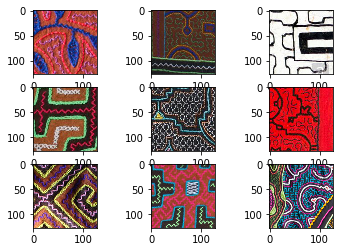

In [25]:
test_indexes = np.random.randint(0,final_count,9)

for i,index in enumerate(test_indexes):
    plt.subplot(3,3,i+1)
    
    plt.imshow(final_imgs[index])
    
plt.show()



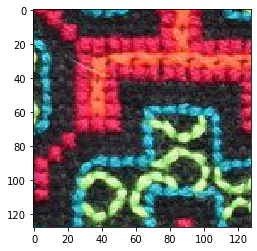

In [24]:
pil_im =  Image.fromarray(np.uint8(final_imgs[1000]))

type(pil_im)

plt.imshow(pil_im)

In [27]:
dest_dir = "../../assets/augment/"

for i,f_im in enumerate(final_imgs):
    
    #create pillow image
    pil_im = Image.fromarray(np.uint8(f_im))
    
    pil_im.save(dest_dir + str(i)+"_128.jpg", "JPEG", subsampling=0, quality=100)
    
    if i % 250 == 0:
        print("saved",i," augmented images")

saved 0  augmented images
saved 250  augmented images
saved 500  augmented images
saved 750  augmented images
saved 1000  augmented images
saved 1250  augmented images
saved 1500  augmented images
saved 1750  augmented images
saved 2000  augmented images
saved 2250  augmented images
saved 2500  augmented images
saved 2750  augmented images
saved 3000  augmented images
saved 3250  augmented images
saved 3500  augmented images
saved 3750  augmented images
saved 4000  augmented images
saved 4250  augmented images
saved 4500  augmented images
saved 4750  augmented images
saved 5000  augmented images
saved 5250  augmented images
saved 5500  augmented images
saved 5750  augmented images
saved 6000  augmented images
saved 6250  augmented images
saved 6500  augmented images
saved 6750  augmented images
saved 7000  augmented images
saved 7250  augmented images
saved 7500  augmented images
saved 7750  augmented images
saved 8000  augmented images
saved 8250  augmented images
saved 8500  augmente

In [32]:
def pre_process_augmented_images(source_dir,destination_dir,final_size=64):
    """ takes the images created from the augmentation process
        and resizes them to another power of 2 factor (32x32, or 64x64)
    """
    
    for i,file in enumerate(os.listdir(source_dir)):
        
        with Image.open(source_dir + file) as im:
            
            r_im = im.resize((final_size,final_size), Image.ANTIALIAS)
            
            r_im.save(destination_dir + str(i)+".jpg", "JPEG", subsampling=0, quality=100)
            
        if i % 250 == 0:
            print("saved",i,"images at resolution:",final_size)

size = 32

source = "../../assets/augment/"
dest = "../../assets/preproc/" + str(size) + "/"

pre_process_augmented_images(source,dest,size)

saved 0 images at resolution: 32
saved 250 images at resolution: 32
saved 500 images at resolution: 32
saved 750 images at resolution: 32
saved 1000 images at resolution: 32
saved 1250 images at resolution: 32
saved 1500 images at resolution: 32
saved 1750 images at resolution: 32
saved 2000 images at resolution: 32
saved 2250 images at resolution: 32
saved 2500 images at resolution: 32
saved 2750 images at resolution: 32
saved 3000 images at resolution: 32
saved 3250 images at resolution: 32
saved 3500 images at resolution: 32
saved 3750 images at resolution: 32
saved 4000 images at resolution: 32
saved 4250 images at resolution: 32
saved 4500 images at resolution: 32
saved 4750 images at resolution: 32
saved 5000 images at resolution: 32
saved 5250 images at resolution: 32
saved 5500 images at resolution: 32
saved 5750 images at resolution: 32
saved 6000 images at resolution: 32
saved 6250 images at resolution: 32
saved 6500 images at resolution: 32
saved 6750 images at resolution: 3